In [288]:
import numpy as np
from numpy.linalg import svd
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt

def aaa(F, Z, tol=1e-13, mmax=50, cleanup_tol=1e-13, verbose=False):
    """
    Adaptive Antoulas–Anderson (AAA) Rational Approximation with cleanup.
    ------------------------------------------------------------
    F : ndarray, function values f(Z)
    Z : ndarray, sample points
    tol : stopping tolerance
    mmax : max number of support points
    cleanup_tol : threshold for small residues (Froissart doublets)
    verbose : if True, print iteration info
    ------------------------------------------------------------
    Returns:
      rfun(z)  : callable rational approximation
      Zs, Fs   : support points and values
      w        : barycentric weights
      poles, zeros, residues : (after cleanup)
    """

    M = len(Z)
    J = np.arange(M)
    S = []
    R = np.zeros_like(F, dtype=complex)
    maxerr_list = []

    # === main AAA loop ===
    for m in range(1, mmax + 1):
        err = np.abs(F - R)
        if m > 1:
            J = np.setdiff1d(np.arange(M), S)
        jmax = J[np.argmax(err[J])]
        S.append(jmax)
        Zs, Fs = Z[S], F[S]
        J = np.setdiff1d(np.arange(M), S)
        Zj, Fj = Z[J], F[J]

        # Cauchy matrix for non-support points
        C = 1.0 / (Zj[:, None] - Zs[None, :])
        # Loewner matrix
        A = (F[J, None]) * C - C * Fs[None, :]

        # SVD smallest singular vector
        _, _, Vh = svd(A, full_matrices=False)
        w = Vh.conj().T[:, -1]

        # Construct approximation on all Z
        C_all = 1.0 / (Z[:, None] - Zs[None, :])
        N = C_all @ (w * Fs)
        D = C_all @ w
        R = N / D
        # enforce interpolation at support points to avoid NaNs
        R[S] = Fs
        maxerr = np.max(np.linalg.norm(F - R))
        maxerr_list.append(maxerr)

        if verbose:
            print(f"Iter {m:2d}: maxerr = {maxerr:.3e}")

        if maxerr < tol * np.max(np.abs(F)):
            break

    # === cleanup: detect Froissart doublets ===
    # compute poles/zeros via polynomial expansion
    num, den = barycentric_to_poly(Zs, Fs, w)
    poles = np.roots(den)
    zeros = np.roots(num)
    residues = compute_residues(num, den, poles)

    # detect small residues
    small_idx = np.where(np.abs(residues) < cleanup_tol)[0]
    if len(small_idx) > 0:
        if verbose:
            print(f"Cleanup: removing {len(small_idx)} Froissart doublets.")
        # remove nearest support points to these poles
        for p in poles[small_idx]:
            nearest = np.argmin(np.abs(Zs - p))
            Zs = np.delete(Zs, nearest)
            Fs = np.delete(Fs, nearest)
        # recompute weights
        J = np.setdiff1d(np.arange(M), np.arange(len(Zs)))
        C = 1.0 / (Z[J][:, None] - Zs[None, :])
        A = (F[J, None]) * C - C * Fs[None, :]
        _, _, Vh = svd(A, full_matrices=False)
        w = Vh.conj().T[:, -1]
        # recompute poles/residues
        num, den = barycentric_to_poly(Zs, Fs, w)
        poles = np.roots(den)
        zeros = np.roots(num)
        residues = compute_residues(num, den, poles)

    return Zs, Fs, w, poles, zeros, residues, maxerr_list


# === Helper: convert barycentric to numerator/denominator polynomial ===
def barycentric_to_poly(Zs, Fs, w):
    """Return numerator and denominator polynomial coefficients.
    n(z) = sum_j w_j f_j prod_{k!=j} (z - z_k)
    d(z) = sum_j w_j     prod_{k!=j} (z - z_k)
    """
    m = len(Zs)
    # p(z) = prod_k (z - z_k)
    p = np.poly(Zs)
    num = np.zeros(m, dtype=complex)  # degree m-1
    den = np.zeros(m, dtype=complex)  # degree m-1
    for j in range(m):
        qj, r = np.polydiv(p, np.array([1.0, -Zs[j]]))  # prod_{k!=j} (z - z_k)
        den += w[j] * qj
        num += w[j] * Fs[j] * qj
    return num, den


# === Helper: compute residues given numerator/denominator ===
def compute_residues(num, den, poles):
    """Compute residues at poles for num/den."""
    num_poly = np.poly1d(num)
    den_poly = np.poly1d(den)
    dprime = np.polyder(den_poly)
    residues = num_poly(poles) / dprime(poles)
    return residues


Iter  1: maxerr = 4.621e+01
Iter  2: maxerr = 1.516e+00
Iter  3: maxerr = 5.927e-02
Iter  4: maxerr = 1.341e-03
Iter  5: maxerr = 5.999e-05
Iter  6: maxerr = 1.850e-06
Iter  7: maxerr = 7.943e-08
Iter  8: maxerr = 3.546e-09
Iter  9: maxerr = 8.186e-11
Iter 10: maxerr = 2.482e-12
Iter 11: maxerr = 7.485e-14


/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:51: RuntimeWarning: divide by zero encountered in divide
  C_all = 1.0 / (Z[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:54: RuntimeWarning: invalid value encountered in divide
  R = N / D
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: divide by zero encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: overflow encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: invalid value encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:53: RuntimeWarning: divide by zero encountered in matmul
  D = C_all @ w
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel

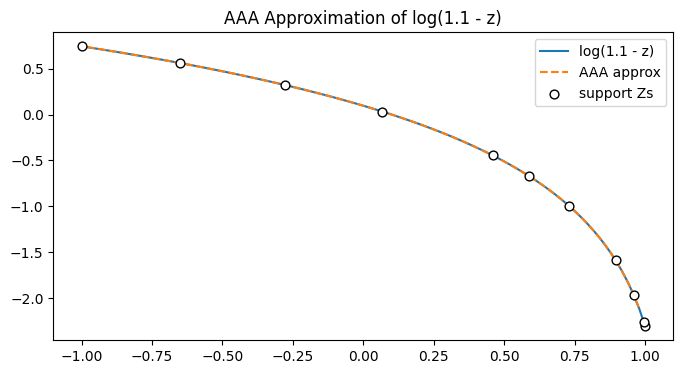

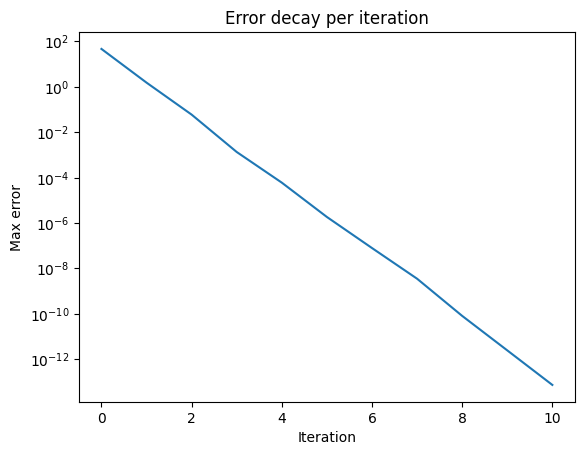

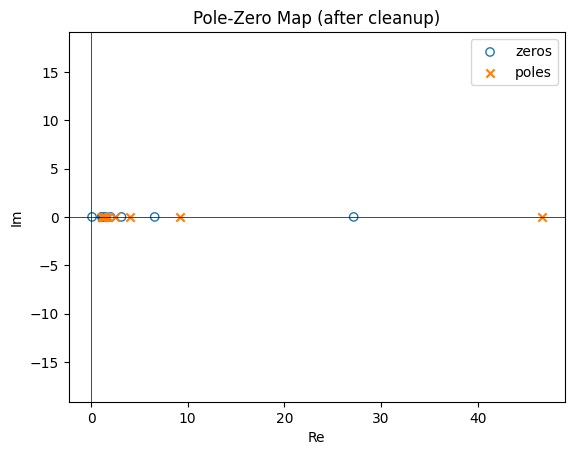

Residues magnitude: [1.18721100e+02 9.92380555e+00 2.54448215e+00 9.70644263e-01
 4.47266448e-01 2.27307443e-01 1.21139064e-01 1.24065129e-02
 3.29724174e-02 6.50396710e-02]


In [289]:
Z = np.linspace(-1, 1, 400)
F = np.log(1.1 - Z)

Zs, Fs, w, poles, zeros, residues, maxerr_list = aaa(F, Z, tol=1e-13, verbose=True)

def rf(z):
    z = np.atleast_1d(z)
    C_eval = 1.0 / (z[:, None] - Zs[None, :])
    return (C_eval @ (w * Fs)) / (C_eval @ w)
# Plot approximation
zz = np.linspace(-1, 1, 100)
plt.figure(figsize=(8,4))
plt.plot(zz, np.log(1.1 - zz), label='log(1.1 - z)')
plt.plot(zz, rf(zz).real, '--', label='AAA approx')
# mark support points on the curve
plt.scatter(Zs, Fs.real, s=40, marker='o', facecolors='w', edgecolors='k', zorder=5, label='support Zs')
plt.legend(); plt.title("AAA Approximation of log(1.1 - z)")
plt.show()

# Error convergence
plt.figure()
plt.semilogy(maxerr_list)
plt.xlabel("Iteration"); plt.ylabel("Max error")
plt.title("Error decay per iteration")
plt.show()

# Pole-Zero map
plt.figure()
zeros = np.asarray(zeros)
poles = np.asarray(poles)
if zeros.size:
    plt.scatter(zeros.real, zeros.imag, marker='o', facecolors='none', edgecolors='tab:blue', label='zeros')
if poles.size:
    plt.scatter(poles.real, poles.imag, marker='x', color='tab:orange', label='poles')
plt.axhline(0, color='k', lw=0.5); plt.axvline(0, color='k', lw=0.5)
plt.legend(); plt.title("Pole-Zero Map (after cleanup)")
plt.xlabel('Re'); plt.ylabel('Im')
plt.axis('equal')
plt.show()

# Check smallest residues (to see Froissart cleanup)
print("Residues magnitude:", np.abs(residues))


/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:51: RuntimeWarning: divide by zero encountered in divide
  C_all = 1.0 / (Z[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:54: RuntimeWarning: invalid value encountered in divide
  R = N / D
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: divide by zero encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: overflow encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: invalid value encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:53: RuntimeWarning: divide by zero encountered in matmul
  D = C_all @ w
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel

Final max error: [np.float64(7858.793420352784), np.float64(514.1325707345914), np.float64(99.33354804061277), np.float64(105.93827262116879), np.float64(32.19821231196645), np.float64(92.36422823894213), np.float64(16.575988474914542), np.float64(6.881357265977755), np.float64(1.5826658370770192), np.float64(79.12878452308428), np.float64(0.3080647403794293), np.float64(1179.9520671116863), np.float64(0.044007606294693434), np.float64(0.4501601912542381), np.float64(0.005692153710054204), np.float64(0.014166364768005235), np.float64(0.0012646859523321578), np.float64(0.003365604519210611), np.float64(0.0002546499484674766), np.float64(0.00033652598301912444), np.float64(2.282919930298491e-05), np.float64(0.0012866327801183601), np.float64(3.4682166452095685e-06), np.float64(1.2412877556548268e-05), np.float64(9.06595557562396e-07), np.float64(6.154410465895703e-07), np.float64(4.8023941143543045e-08), np.float64(1.2920055261515957e-07), np.float64(1.1796619374921685e-08), np.float64(3

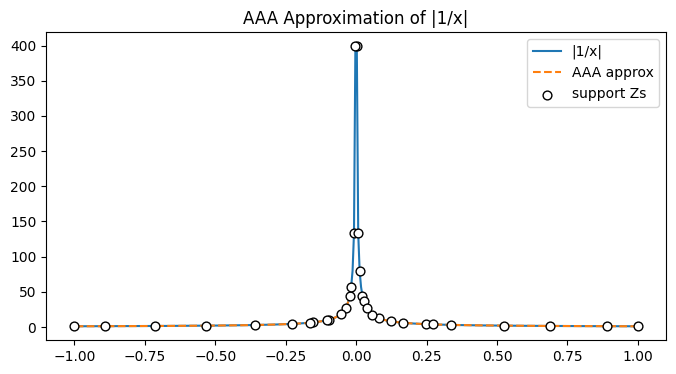

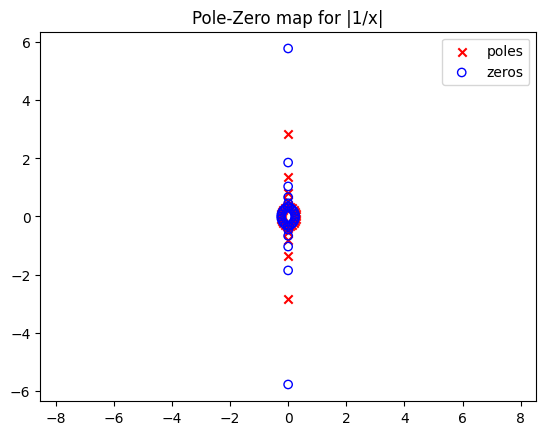

In [290]:
Z = np.linspace(-1, 1, 400)
F = np.abs(1/Z)

Zs, Fs, w, poles, zeros, residues, errs = aaa(F, Z, tol=1e-12)
print("Final max error:", errs)
print(len(Zs), "support points selected.")
# define rf for this problem instance
def rf(z):
    z = np.atleast_1d(z)
    C_eval = 1.0 / (z[:, None] - Zs[None, :])
    return (C_eval @ (w * Fs)) / (C_eval @ w)

zz = np.linspace(-1, 1, 400)
plt.figure(figsize=(8,4))
plt.plot(zz, F, label='|1/x|')
plt.plot(zz, rf(zz).real, '--', label='AAA approx')
# mark support points on the curve
plt.scatter(Zs, Fs.real, s=40, marker='o', facecolors='w', edgecolors='k', zorder=5, label='support Zs')
plt.legend(); plt.title("AAA Approximation of |1/x|")
plt.show()

plt.figure()
plt.scatter(poles.real, poles.imag, color='r', marker='x', label='poles')
plt.scatter(zeros.real, zeros.imag, facecolors='none', edgecolors='b', marker='o', label='zeros')
plt.axis('equal'); plt.legend(); plt.title("Pole-Zero map for |1/x|")
plt.show()


11 support points selected.


/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:51: RuntimeWarning: divide by zero encountered in divide
  C_all = 1.0 / (Z[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:54: RuntimeWarning: invalid value encountered in divide
  R = N / D
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: divide by zero encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: overflow encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: invalid value encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:53: RuntimeWarning: divide by zero encountered in matmul
  D = C_all @ w
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel

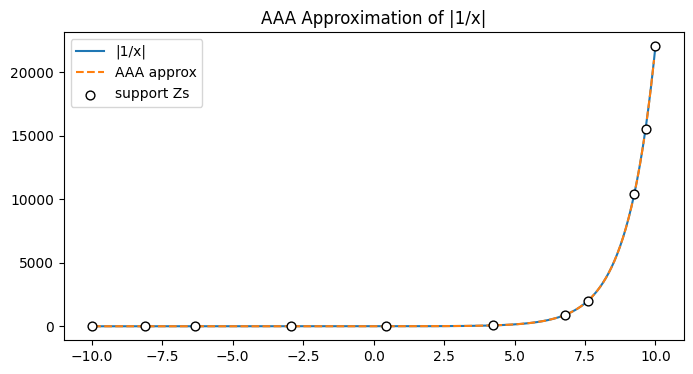

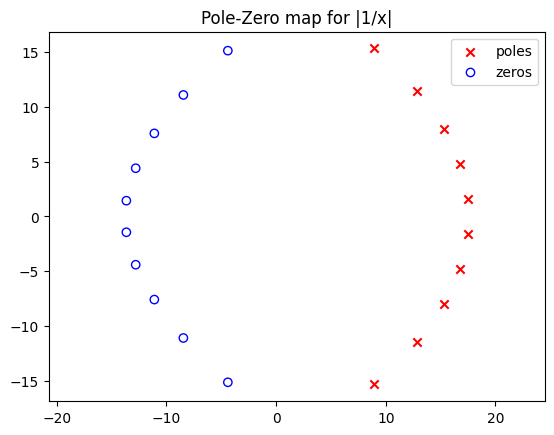

In [291]:
Z = np.linspace(-10, 10, 400)
F = np.exp(Z)

Zs, Fs, w, poles, zeros, residues, errs = aaa(F, Z, tol=1e-12)
print(len(Zs), "support points selected.")
# define rf for this problem instance
def rf(z):
    z = np.atleast_1d(z)
    C_eval = 1.0 / (z[:, None] - Zs[None, :])
    return (C_eval @ (w * Fs)) / (C_eval @ w)

zz = np.linspace(-10, 10, 400)
plt.figure(figsize=(8,4))
plt.plot(zz, F, label='|1/x|')
plt.plot(zz, rf(zz).real, '--', label='AAA approx')
# mark support points on the curve
plt.scatter(Zs, Fs.real, s=40, marker='o', facecolors='w', edgecolors='k', zorder=5, label='support Zs')
plt.legend(); plt.title("AAA Approximation of |1/x|")
plt.show()

plt.figure()
plt.scatter(poles.real, poles.imag, color='r', marker='x', label='poles')
plt.scatter(zeros.real, zeros.imag, facecolors='none', edgecolors='b', marker='o', label='zeros')
plt.axis('equal'); plt.legend(); plt.title("Pole-Zero map for |1/x|")
plt.show()


In [292]:
import numpy as np
from numpy.linalg import svd

def aaa_complex(F, Z, tol=1e-13, mmax=50, cleanup=True, verbose=False):
    """
    AAA rational approximation (complex-capable)
    
    Parameters
    ----------
    F : array_like (complex)
        Sample values f(z_i)
    Z : array_like (complex)
        Sample points z_i
    tol : float
        Relative tolerance for stopping criterion
    mmax : int
        Maximum number of support points
    cleanup : bool
        Whether to perform Froissart doublet removal
    verbose : bool
        If True, print iteration diagnostics

    Returns
    -------
    rfun : callable
        Rational approximation function r(z)
    Zs, Fs, w : arrays
        Support points, values, and barycentric weights
    """

    F = np.asarray(F, dtype=complex)
    Z = np.asarray(Z, dtype=complex)
    M = len(Z)
    R = np.zeros_like(F)
    J = np.arange(M)
    S = []

    for m in range(1, mmax + 1):
        # 1. Select new support point (max residual)
        jmax = np.argmax(np.abs(F - R))
        S.append(jmax)
        J = np.setdiff1d(np.arange(M), S)
        
        Zs, Fs = Z[S], F[S]
        Zj, Fj = Z[J], F[J]
        
        # 2. Build Cauchy & Loewner matrices on non-support set
        C = 1.0 / (Zj[:, None] - Zs[None, :])
        A = Fj[:, None] * C - C * Fs[None, :]

        # 3. Compute weights via SVD (smallest singular vector)
        _, _, Vh = svd(A, full_matrices=False)
        w = Vh.conj().T[:, -1]

        # 4. Evaluate rational approximation on full Z (enforce interpolation at support points)
        C_all = 1.0 / (Z[:, None] - Zs[None, :])
        num_all = C_all @ (w * Fs)
        den_all = C_all @ w
        R = num_all / den_all
        R[S] = Fs

        # 5. Check convergence using max error over all samples
        err = np.max(np.abs(F - R))
        if verbose:
            print(f"Iter {m}: max|err| = {err:.3e}")
        if err < tol * np.max(np.abs(F)):
            break

    # 6. Optional cleanup
    if cleanup:
        Zs, Fs, w = aaa_cleanup(Zs, Fs, w, tol, F)

    # 7. Return callable rational function
    def rfun(z):
        z = np.asarray(z, dtype=complex)
        C_eval = 1.0 / (z[:, None] - Zs[None, :])
        return (C_eval @ (w * Fs)) / (C_eval @ w)

    return rfun, Zs, Fs, w


def aaa_cleanup(Zs, Fs, w, tol, F):
    """Remove Froissart doublets (spurious pole-zero pairs)."""
    def n(z): return np.sum(w * Fs / (z - Zs))
    def d(z): return np.sum(w / (z - Zs))
    def dprime(z): return -np.sum(w / (z - Zs)**2)

    # find poles (roots of denominator)
    coeffs = np.zeros(len(Zs), dtype=complex)
    for j in range(len(Zs)):
        others = np.delete(Zs, j)
        poly_j = np.poly(others)
        coeffs[:len(poly_j)] += w[j] * poly_j
    poles = np.roots(coeffs)

    # compute residues
    c = np.array([n(p)/dprime(p) for p in poles])
    mask = np.abs(c) < tol * np.max(np.abs(F))
    if np.any(mask):
        # remove nearest support points to spurious poles
        for p in poles[mask]:
            j_near = np.argmin(np.abs(Zs - p))
            Zs = np.delete(Zs, j_near)
            Fs = np.delete(Fs, j_near)
            w = np.delete(w, j_near)
    return Zs, Fs, w

/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:56: RuntimeWarning: divide by zero encountered in divide
  C_all = 1.0 / (Z[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:56: RuntimeWarning: invalid value encountered in divide
  C_all = 1.0 / (Z[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:57: RuntimeWarning: invalid value encountered in matmul
  num_all = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:58: RuntimeWarning: invalid value encountered in matmul
  den_all = C_all @ w
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:59: RuntimeWarning: invalid value encountered in divide
  R = num_all / den_all
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:57: RuntimeWarning: divide by zero encountered in matmul
  num_all = C_all @ (w * Fs

Iter 1: max|err| = 2.371e+00
Iter 2: max|err| = 2.119e-01
Iter 3: max|err| = 3.318e-03
Iter 4: max|err| = 3.924e-05
Iter 5: max|err| = 1.372e-07
Iter 6: max|err| = 3.733e-10
Iter 7: max|err| = 5.783e-13


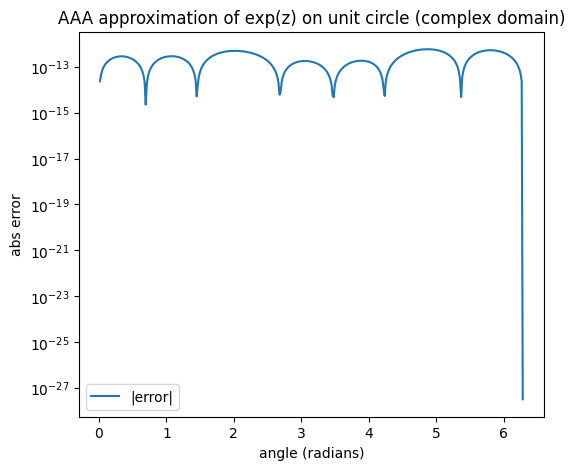

In [293]:
# Example: approximate f(z) = exp(z) over complex circle

theta = np.linspace(0, 2*np.pi, 200)
Z = np.exp(1j * theta)       # points on unit circle
F = np.exp(Z)                # complex function values

rfun, Zs, Fs, w = aaa_complex(F, Z, tol=1e-12, verbose=True)

# Evaluate on a grid
theta_test = np.linspace(0, 2*np.pi, 400)
Zt = np.exp(1j * theta_test)
F_true = np.exp(Zt)
F_approx = rfun(Zt)

plt.figure(figsize=(6,5))
plt.plot(theta_test, np.abs(F_true - F_approx), label='|error|')
plt.yscale('log')
plt.xlabel('angle (radians)')
plt.ylabel('abs error')
plt.title('AAA approximation of exp(z) on unit circle (complex domain)')
plt.legend()
plt.show()


## More diagnostic plots
We add extra visualizations to better understand the AAA approximation:
- Absolute error vs input
- Denominator magnitude |d(z)| to hint at pole proximity
- Barycentric weight magnitudes |w_j|
- For the complex example: support points on the unit circle and real/imag part comparisons

/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/1766766825.py:8: RuntimeWarning: divide by zero encountered in divide
  C = 1.0 / (z[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/1766766825.py:8: RuntimeWarning: invalid value encountered in divide
  C = 1.0 / (z[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/1766766825.py:12: RuntimeWarning: divide by zero encountered in matmul
  num = C @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/1766766825.py:12: RuntimeWarning: overflow encountered in matmul
  num = C @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/1766766825.py:12: RuntimeWarning: invalid value encountered in matmul
  num = C @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/1766766825.py:13: RuntimeWarning: divide by zero encountered in matmul
  den = C @ w
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp7

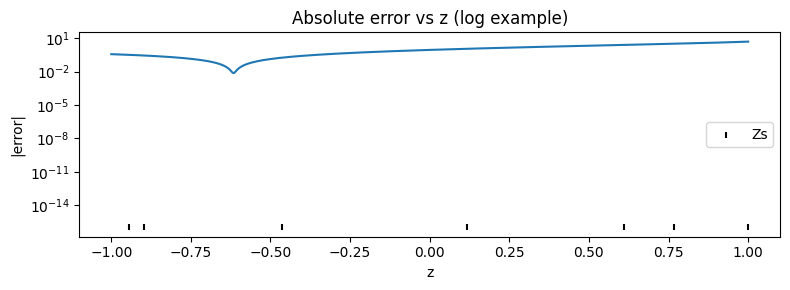

/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/1766766825.py:30: RuntimeWarning: divide by zero encountered in divide
  C_line = 1.0 / (zz_fine[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/1766766825.py:30: RuntimeWarning: invalid value encountered in divide
  C_line = 1.0 / (zz_fine[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/1766766825.py:31: RuntimeWarning: divide by zero encountered in matmul
  den_line = np.abs(C_line @ w)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/1766766825.py:31: RuntimeWarning: overflow encountered in matmul
  den_line = np.abs(C_line @ w)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/1766766825.py:31: RuntimeWarning: invalid value encountered in matmul
  den_line = np.abs(C_line @ w)


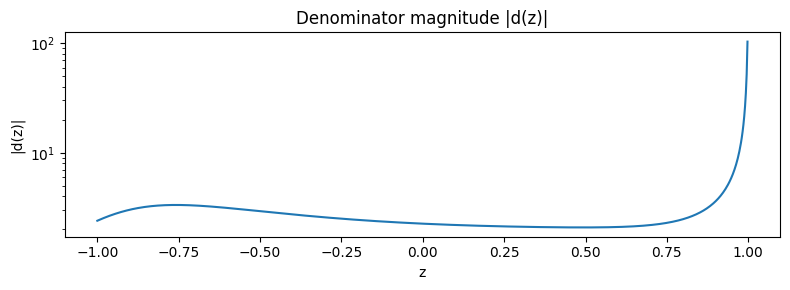

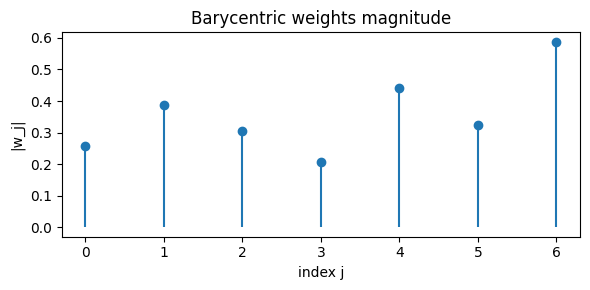

In [294]:
# Extra plots for the real-example (log)
# Uses variables from Cell 2: Z, F, Zs, Fs, w, rf

# Safe barycentric evaluation that returns Fs at support points

def eval_rf_safe(z, Zs, Fs, w, tol=1e-12):
    z = np.atleast_1d(z)
    C = 1.0 / (z[:, None] - Zs[None, :])
    dist = np.abs(z[:, None] - Zs[None, :])
    idx_closest = dist.argmin(axis=1)
    hit = dist[np.arange(len(z)), idx_closest] < tol
    num = C @ (w * Fs)
    den = C @ w
    out = num / den
    if np.any(hit):
        out[hit] = Fs[idx_closest[hit]]
    return out

# 1) Absolute error vs z
zz_fine = np.linspace(Z.min(), Z.max(), 800)
F_true = np.log(1.1 - zz_fine)
F_approx = eval_rf_safe(zz_fine, Zs, Fs, w).real
plt.figure(figsize=(8,3))
plt.semilogy(zz_fine, np.abs(F_true - F_approx))
plt.scatter(Zs, np.full_like(Zs, 1e-16), s=20, marker='|', color='k', label='Zs')
plt.xlabel('z'); plt.ylabel('|error|'); plt.title('Absolute error vs z (log example)')
plt.legend(); plt.tight_layout(); plt.show()

# 2) Denominator magnitude along z grid (mask near support points)
C_line = 1.0 / (zz_fine[:, None] - Zs[None, :])
den_line = np.abs(C_line @ w)
dist_line = np.min(np.abs(zz_fine[:, None] - Zs[None, :]), axis=1)
den_line[dist_line < 1e-12] = np.nan
plt.figure(figsize=(8,3))
plt.semilogy(zz_fine, den_line)
plt.xlabel('z'); plt.ylabel('|d(z)|'); plt.title('Denominator magnitude |d(z)|')
plt.tight_layout(); plt.show()

# 3) Barycentric weight magnitudes
plt.figure(figsize=(6,3))
plt.stem(np.arange(len(w)), np.abs(w), basefmt=' ')
plt.xlabel('index j'); plt.ylabel('|w_j|'); plt.title('Barycentric weights magnitude')
plt.tight_layout(); plt.show()

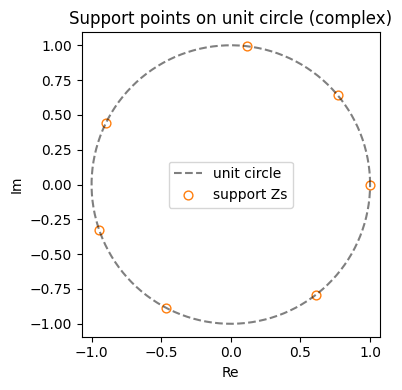

/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:76: RuntimeWarning: divide by zero encountered in divide
  C_eval = 1.0 / (z[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:76: RuntimeWarning: invalid value encountered in divide
  C_eval = 1.0 / (z[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:77: RuntimeWarning: divide by zero encountered in matmul
  return (C_eval @ (w * Fs)) / (C_eval @ w)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:77: RuntimeWarning: overflow encountered in matmul
  return (C_eval @ (w * Fs)) / (C_eval @ w)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:77: RuntimeWarning: invalid value encountered in matmul
  return (C_eval @ (w * Fs)) / (C_eval @ w)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:77: RuntimeWarning: invalid v

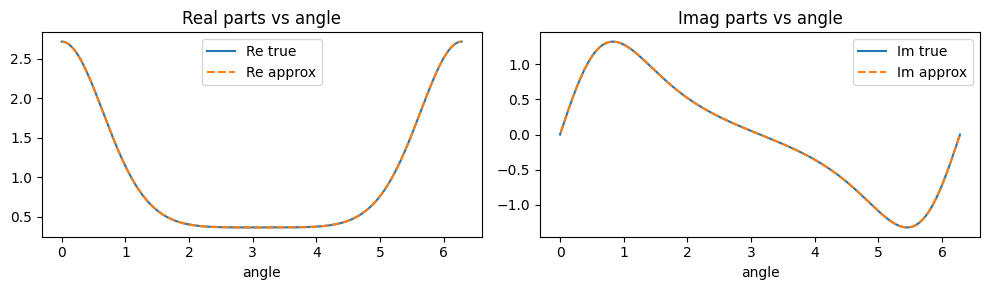

In [295]:
# Extra plots for the complex circle example
# Assumes variables from complex example cell: theta, Z, F, rfun, Zs, Fs, w

# 1) Support points on the unit circle
plt.figure(figsize=(4,4))
ang = np.angle(Zs)
uc = np.exp(1j * np.linspace(0, 2*np.pi, 400))
plt.plot(uc.real, uc.imag, 'k--', alpha=0.5, label='unit circle')
plt.scatter(Zs.real, Zs.imag, facecolors='w', edgecolors='C1', s=40, label='support Zs')
plt.axis('equal'); plt.xlabel('Re'); plt.ylabel('Im')
plt.title('Support points on unit circle (complex)')
plt.legend(); plt.tight_layout(); plt.show()

# 2) Real/Imag comparisons along the circle
Zt = np.exp(1j * np.linspace(0, 2*np.pi, 600))
F_true = np.exp(Zt)
F_approx = rfun(Zt)
th = np.linspace(0, 2*np.pi, len(Zt))

fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].plot(th, F_true.real, label='Re true')
ax[0].plot(th, F_approx.real, '--', label='Re approx')
ax[0].set_title('Real parts vs angle'); ax[0].set_xlabel('angle'); ax[0].legend()
ax[1].plot(th, F_true.imag, label='Im true')
ax[1].plot(th, F_approx.imag, '--', label='Im approx')
ax[1].set_title('Imag parts vs angle'); ax[1].set_xlabel('angle'); ax[1].legend()
plt.tight_layout(); plt.show()


## Simulating the Riemann zeta function ζ(s)

We add a lightweight numerical evaluator for ζ(s):
- Prefer high-precision `mpmath.zeta` when available.
- Fallback to the Dirichlet eta series η(s) which converges for Re(s) > 0 via ζ(s) = η(s) / (1 − 2^{1−s}).

Then we show two demos:
- Real axis: s ∈ [1.1, 4]
- Critical line: s = 1/2 + it, t ∈ [0, 40]


In [296]:
# Lightweight Riemann zeta evaluator (mpmath fallback + Dirichlet eta series)
import numpy as np
import matplotlib.pyplot as plt

try:
    import mpmath as mp
    HAVE_MPMATH = True
    mp.mp.dps = 50  # working precision
except Exception:
    HAVE_MPMATH = False


def zeta_mpmath(s):
    """Evaluate ζ(s) using mpmath for complex or real arrays s."""
    s = np.asarray(s, dtype=complex)
    out = np.empty(s.shape, dtype=complex)
    for idx, val in np.ndenumerate(s):
        out[idx] = complex(mp.zeta(val))
    return out


def zeta_eta(s, N=2000):
    """Evaluate ζ(s) via the alternating Dirichlet eta series.
    η(s) = sum_{n>=1} (-1)^{n-1} n^{-s},  ζ(s) = η(s) / (1 - 2^{1-s}).
    Converges for Re(s) > 0 (s ≠ 1). N controls truncation."""
    s = np.asarray(s, dtype=complex)
    s_flat = s.reshape(-1)
    n = np.arange(1, N + 1, dtype=float)
    alt = 1.0 - 2.0 * (n % 2 == 0)  # +1, -1, +1, -1, ...
    with np.errstate(over='ignore', invalid='ignore', divide='ignore'):
        terms = alt[:, None] * np.power(n[:, None], -s_flat[None, :])
    eta = np.sum(terms, axis=0)
    denom = 1.0 - np.power(2.0, 1.0 - s_flat)
    z = eta / denom
    return z.reshape(s.shape)


def zeta(s, N=2000):
    """Convenience wrapper: prefer mpmath if present, else eta-series.
    N is used only for the eta-series fallback."""
    if HAVE_MPMATH:
        try:
            return zeta_mpmath(s)
        except Exception:
            pass
    return zeta_eta(s, N=N)


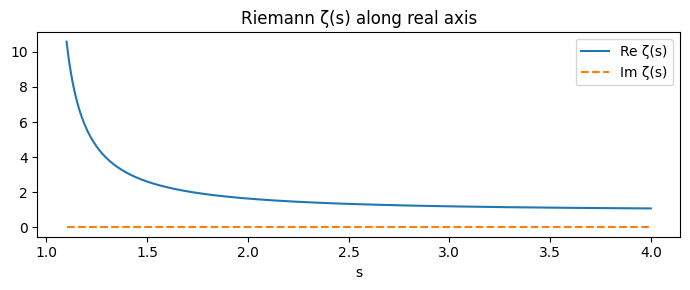

In [297]:
# Demo 1: Real axis s ∈ [1.1, 4]
s = np.linspace(1.1, 4.0, 400)
z = zeta(s, N=2000)

plt.figure(figsize=(7,3))
plt.plot(s, z.real, label='Re ζ(s)')
plt.plot(s, z.imag, '--', label='Im ζ(s)')
plt.title('Riemann ζ(s) along real axis')
plt.xlabel('s'); plt.legend(); plt.tight_layout(); plt.show()


/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:51: RuntimeWarning: divide by zero encountered in divide
  C_all = 1.0 / (Z[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: invalid value encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:53: RuntimeWarning: invalid value encountered in matmul
  D = C_all @ w
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:54: RuntimeWarning: invalid value encountered in divide
  R = N / D
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: divide by zero encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: overflow encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_

Iter  1: maxerr = 1.977e+02
Iter  2: maxerr = 9.175e-01
Iter  3: maxerr = 5.034e-03
Iter  4: maxerr = 5.618e-06
Iter  5: maxerr = 2.382e-08
Iter  6: maxerr = 8.988e-12


/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/1919681967.py:25: RuntimeWarning: divide by zero encountered in divide
  C_eval = 1.0 / (s[:, None] - Zs_r[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/1919681967.py:27: RuntimeWarning: divide by zero encountered in matmul
  return (C_eval @ (w_r * Fs_r)) / (C_eval @ w_r)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/1919681967.py:27: RuntimeWarning: overflow encountered in matmul
  return (C_eval @ (w_r * Fs_r)) / (C_eval @ w_r)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/1919681967.py:27: RuntimeWarning: invalid value encountered in matmul
  return (C_eval @ (w_r * Fs_r)) / (C_eval @ w_r)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/1919681967.py:27: RuntimeWarning: invalid value encountered in divide
  return (C_eval @ (w_r * Fs_r)) / (C_eval @ w_r)


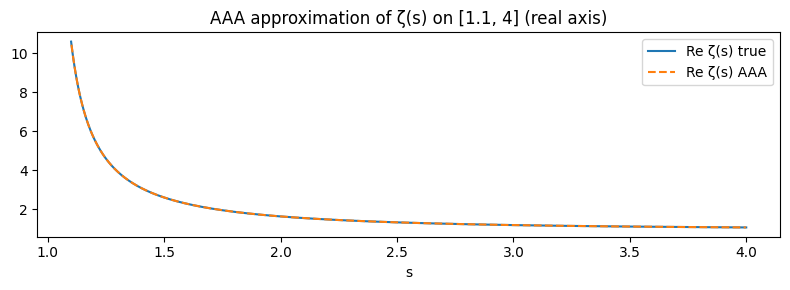

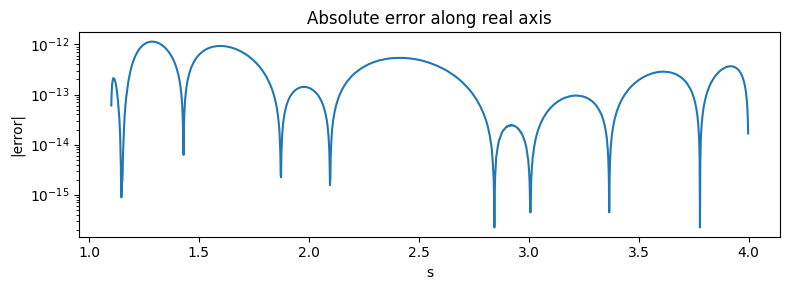

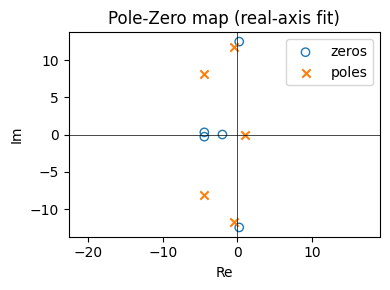

Real-axis AAA: support points = 6  final maxerr ~ 8.987758864265529e-12


/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:56: RuntimeWarning: divide by zero encountered in divide
  C_all = 1.0 / (Z[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:56: RuntimeWarning: invalid value encountered in divide
  C_all = 1.0 / (Z[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:58: RuntimeWarning: invalid value encountered in matmul
  den_all = C_all @ w
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:59: RuntimeWarning: invalid value encountered in divide
  R = num_all / den_all
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:57: RuntimeWarning: divide by zero encountered in matmul
  num_all = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:57: RuntimeWarning: overflow encountered in matmul
  num_all = C_all @ (w * Fs)
/va

Iter 1: max|err| = 4.402e+00
Iter 2: max|err| = 1.357e+01
Iter 3: max|err| = 2.153e+00
Iter 4: max|err| = 2.803e+00
Iter 5: max|err| = 7.275e+00
Iter 6: max|err| = 4.651e+00
Iter 7: max|err| = 1.785e+00
Iter 8: max|err| = 3.334e+00
Iter 9: max|err| = 3.542e+00
Iter 10: max|err| = 2.750e-01
Iter 11: max|err| = 1.158e-02
Iter 12: max|err| = 6.837e-03
Iter 13: max|err| = 6.372e-04
Iter 14: max|err| = 1.158e-04
Iter 15: max|err| = 3.270e-06
Iter 16: max|err| = 4.084e-07
Iter 17: max|err| = 8.391e-08
Iter 18: max|err| = 2.075e-09
Iter 19: max|err| = 9.667e-11
Iter 20: max|err| = 9.019e-12
Iter 21: max|err| = 1.364e-12
Iter 22: max|err| = 7.911e-14
Iter 23: max|err| = 8.875e-14
Iter 24: max|err| = 8.165e-15
Iter 25: max|err| = 1.155e-14
Iter 26: max|err| = 7.162e-14
Iter 27: max|err| = 1.368e-13
Iter 28: max|err| = 8.749e-14
Iter 29: max|err| = 2.151e-14
Iter 30: max|err| = 4.216e-14
Iter 31: max|err| = 1.027e-14
Iter 32: max|err| = 3.033e-14
Iter 33: max|err| = 1.336e-14
Iter 34: max|err| =

/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:77: RuntimeWarning: divide by zero encountered in matmul
  return (C_eval @ (w * Fs)) / (C_eval @ w)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:77: RuntimeWarning: overflow encountered in matmul
  return (C_eval @ (w * Fs)) / (C_eval @ w)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:77: RuntimeWarning: invalid value encountered in matmul
  return (C_eval @ (w * Fs)) / (C_eval @ w)


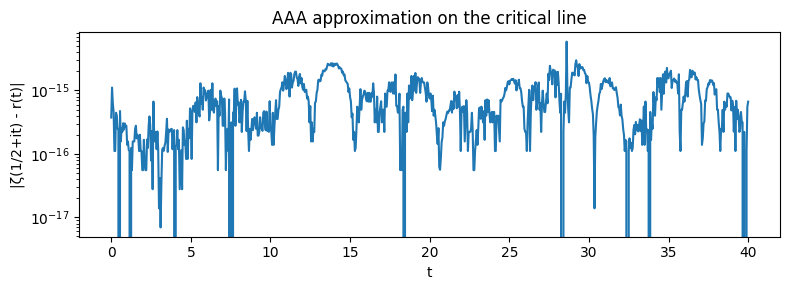

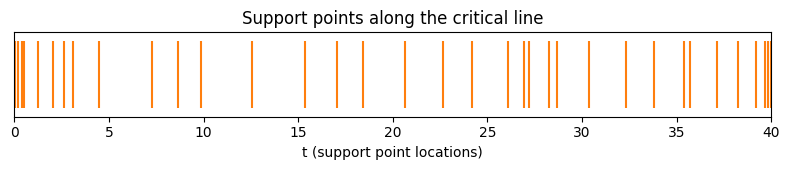

In [298]:
# AAA approximation of the Riemann zeta ζ(s)

import numpy as np

import matplotlib.pyplot as plt



# A) Real axis: s ∈ [1.1, 4]

s_train = np.linspace(1.1, 4.0, 500)

F_train = zeta(s_train, N=2000)  # complex array but real-valued for s>1



Zs_r, Fs_r, w_r, poles_r, zeros_r, residues_r, errs_r = aaa(F_train, s_train, tol=1e-12, mmax=60, verbose=True)



def rfun_real(s):

    s = np.atleast_1d(s)

    C_eval = 1.0 / (s[:, None] - Zs_r[None, :])

    return (C_eval @ (w_r * Fs_r)) / (C_eval @ w_r)



# Evaluate on a denser grid for validation

s_test = np.linspace(1.1, 4.0, 1800)
F_true = zeta(s_test, N=2000)
F_approx = rfun_real(s_test)

plt.figure(figsize=(8,3))
plt.plot(s_test, F_true.real, label='Re ζ(s) true')
plt.plot(s_test, F_approx.real, '--', label='Re ζ(s) AAA')
plt.title('AAA approximation of ζ(s) on [1.1, 4] (real axis)')
plt.xlabel('s'); plt.legend(); plt.tight_layout(); plt.show()



plt.figure(figsize=(8,3))
plt.semilogy(s_test, np.abs(F_true - F_approx))
plt.xlabel('s'); plt.ylabel('|error|')
plt.title('Absolute error along real axis')
plt.tight_layout(); plt.show()



# Pole-Zero map (after cleanup)

plt.figure(figsize=(4,3))

if len(zeros_r):

    plt.scatter(np.real(zeros_r), np.imag(zeros_r), facecolors='none', edgecolors='tab:blue', label='zeros')

if len(poles_r):

    plt.scatter(np.real(poles_r), np.imag(poles_r), marker='x', color='tab:orange', label='poles')

plt.axhline(0, color='k', lw=0.5); plt.axvline(0, color='k', lw=0.5)

plt.legend(); plt.title('Pole-Zero map (real-axis fit)'); plt.xlabel('Re'); plt.ylabel('Im'); plt.axis('equal')

plt.tight_layout(); plt.show()



print('Real-axis AAA: support points =', len(Zs_r), ' final maxerr ~', (errs_r[-1] if errs_r else None))



# B) Critical line: s = 1/2 + i t,  t ∈ [0, 40]

t_train = np.random.uniform(0.0, 40.0, 800)

s_line = 0.5 + 1j * t_train

F_line = zeta(s_line, N=2000)



rfun_c, Zs_c, Fs_c, w_c = aaa_complex(F_line, s_line, tol=1e-15, mmax=800, verbose=True)



# Validate on a slightly different grid to avoid exact support-point evaluation

t_test = np.linspace(0.0, 40.0, 801)

s_test_c = 0.5 + 1j * t_test

F_true_c = zeta(s_test_c, N=2000)

F_approx_c = rfun_c(s_test_c)



plt.figure(figsize=(8,3))

plt.semilogy(t_test, np.abs(F_true_c - F_approx_c), label='|error|')

plt.xlabel('t'); plt.ylabel('|ζ(1/2+it) - r(t)|')

plt.title('AAA approximation on the critical line')

plt.tight_layout(); plt.show()



# Show where AAA picked support points along t

plt.figure(figsize=(8,1.8))

plt.eventplot(np.imag(Zs_c), colors='C1', lineoffsets=0.5, linelengths=0.8)

plt.xlim(0, 40); plt.ylim(0,1)

plt.yticks([]); plt.xlabel('t (support point locations)')

plt.title('Support points along the critical line')

plt.tight_layout(); plt.show()

/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:51: RuntimeWarning: divide by zero encountered in divide
  C_all = 1.0 / (Z[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: invalid value encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:53: RuntimeWarning: invalid value encountered in matmul
  D = C_all @ w
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:54: RuntimeWarning: invalid value encountered in divide
  R = N / D
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: divide by zero encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: overflow encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_

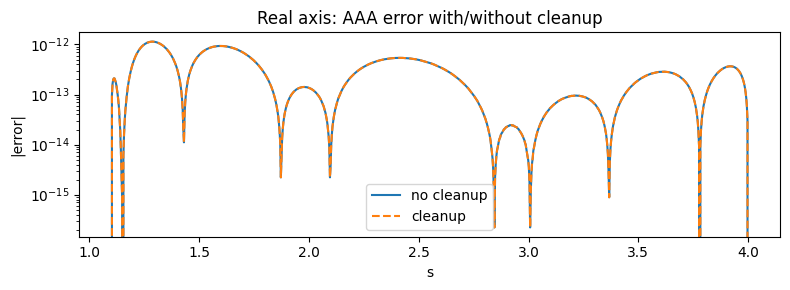

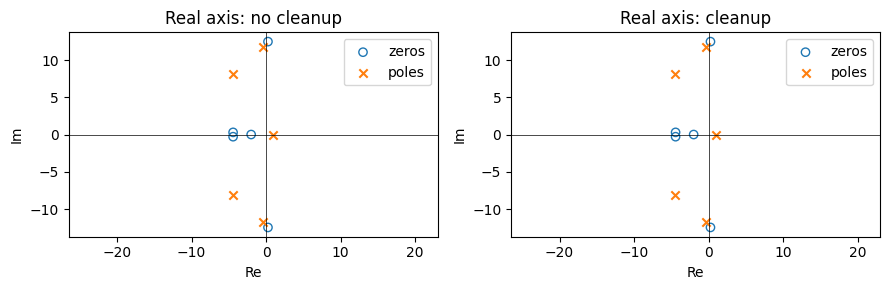

Real axis: support points (raw, clean) = 6 6
Real axis: final maxerr (raw, clean) ~ 8.987758864265529e-12 8.987758864265529e-12


/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:56: RuntimeWarning: divide by zero encountered in divide
  C_all = 1.0 / (Z[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:56: RuntimeWarning: invalid value encountered in divide
  C_all = 1.0 / (Z[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:58: RuntimeWarning: invalid value encountered in matmul
  den_all = C_all @ w
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:59: RuntimeWarning: invalid value encountered in divide
  R = num_all / den_all
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:57: RuntimeWarning: divide by zero encountered in matmul
  num_all = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:57: RuntimeWarning: overflow encountered in matmul
  num_all = C_all @ (w * Fs)
/va

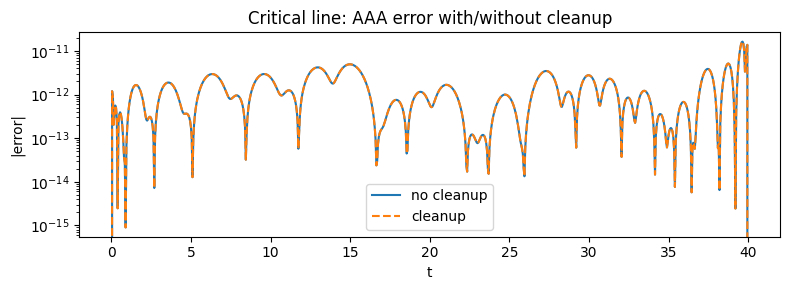

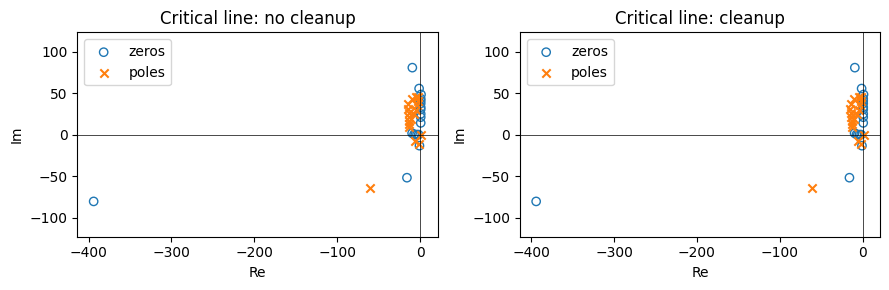

Critical line: support points (raw, clean) = 20 20


In [299]:
# Comparison: AAA with vs without cleanup for ζ(s)

import numpy as np

import matplotlib.pyplot as plt



# --- Real axis: s ∈ [1.1, 4] ---

s_train = np.linspace(1.1, 4.0, 500)

F_train = zeta(s_train, N=2000)



# Run AAA without cleanup (disable by using a negative cleanup_tol)

Zs_raw_r, Fs_raw_r, w_raw_r, poles_raw_r, zeros_raw_r, residues_raw_r, errs_raw_r = aaa(

    F_train, s_train, tol=1e-12, mmax=60, cleanup_tol=-1, verbose=False

)



# Run AAA with cleanup (default)

Zs_clean_r, Fs_clean_r, w_clean_r, poles_clean_r, zeros_clean_r, residues_clean_r, errs_clean_r = aaa(

    F_train, s_train, tol=1e-12, mmax=60, cleanup_tol=1e-13, verbose=False

)



# Safe evaluator to avoid warnings at support points

def r_eval_safe(z, Zs, Fs, w):

    return eval_rf_safe(z, Zs, Fs, w)



s_test = np.linspace(1.1, 4.0, 1000)

F_true = zeta(s_test, N=2000)

F_raw = r_eval_safe(s_test, Zs_raw_r, Fs_raw_r, w_raw_r)

F_clean = r_eval_safe(s_test, Zs_clean_r, Fs_clean_r, w_clean_r)



# Error curves

plt.figure(figsize=(8,3))

plt.semilogy(s_test, np.abs(F_true - F_raw), label='no cleanup')

plt.semilogy(s_test, np.abs(F_true - F_clean), '--', label='cleanup')

plt.xlabel('s'); plt.ylabel('|error|'); plt.title('Real axis: AAA error with/without cleanup')

plt.legend(); plt.tight_layout(); plt.show()



# Pole–Zero comparison

fig, ax = plt.subplots(1, 2, figsize=(9,3))

for j,(p,z_,title_) in enumerate([

    (poles_raw_r, zeros_raw_r, 'no cleanup'),

    (poles_clean_r, zeros_clean_r, 'cleanup')

]):

    if len(z_):

        ax[j].scatter(np.real(z_), np.imag(z_), facecolors='none', edgecolors='tab:blue', label='zeros')

    if len(p):

        ax[j].scatter(np.real(p), np.imag(p), marker='x', color='tab:orange', label='poles')

    ax[j].axhline(0, color='k', lw=0.5); ax[j].axvline(0, color='k', lw=0.5)

    ax[j].set_title(f'Real axis: {title_}')

    ax[j].set_xlabel('Re'); ax[j].set_ylabel('Im'); ax[j].axis('equal')

    ax[j].legend(loc='best')

plt.tight_layout(); plt.show()



print('Real axis: support points (raw, clean) =', len(Zs_raw_r), len(Zs_clean_r))

print('Real axis: final maxerr (raw, clean) ~', (errs_raw_r[-1] if errs_raw_r else None), (errs_clean_r[-1] if errs_clean_r else None))



# --- Critical line: s = 1/2 + it,  t ∈ [0, 40] ---

t_train = np.linspace(0.0, 40.0, 800)

s_line = 0.5 + 1j * t_train

F_line = zeta(s_line, N=2000)



# Without cleanup

rfun_raw_c, Zs_raw_c, Fs_raw_c, w_raw_c = aaa_complex(F_line, s_line, tol=1e-11, mmax=80, cleanup=False, verbose=False)

# With cleanup

rfun_clean_c, Zs_clean_c, Fs_clean_c, w_clean_c = aaa_complex(F_line, s_line, tol=1e-11, mmax=80, cleanup=True, verbose=False)



# Evaluate and compare errors

t_test = np.linspace(0.0, 40.0, 801)

s_test_c = 0.5 + 1j * t_test

F_true_c = zeta(s_test_c, N=2000)

F_raw_c = r_eval_safe(s_test_c, Zs_raw_c, Fs_raw_c, w_raw_c)

F_clean_c = r_eval_safe(s_test_c, Zs_clean_c, Fs_clean_c, w_clean_c)



plt.figure(figsize=(8,3))

plt.semilogy(t_test, np.abs(F_true_c - F_raw_c), label='no cleanup')

plt.semilogy(t_test, np.abs(F_true_c - F_clean_c), '--', label='cleanup')

plt.xlabel('t'); plt.ylabel('|error|'); plt.title('Critical line: AAA error with/without cleanup')

plt.legend(); plt.tight_layout(); plt.show()



# Pole–Zero comparison for complex fit via barycentric_to_poly

def poles_zeros_from_bary(Zs, Fs, w):

    num, den = barycentric_to_poly(Zs, Fs, w)

    return np.roots(den), np.roots(num)



p_raw_c, z_raw_c = poles_zeros_from_bary(Zs_raw_c, Fs_raw_c, w_raw_c)

p_clean_c, z_clean_c = poles_zeros_from_bary(Zs_clean_c, Fs_clean_c, w_clean_c)



fig, ax = plt.subplots(1, 2, figsize=(9,3))

for j,(p,z_,title_) in enumerate([

    (p_raw_c, z_raw_c, 'no cleanup'),

    (p_clean_c, z_clean_c, 'cleanup')

]):

    if len(z_):

        ax[j].scatter(np.real(z_), np.imag(z_), facecolors='none', edgecolors='tab:blue', label='zeros')

    if len(p):

        ax[j].scatter(np.real(p), np.imag(p), marker='x', color='tab:orange', label='poles')

    ax[j].axhline(0, color='k', lw=0.5); ax[j].axvline(0, color='k', lw=0.5)

    ax[j].set_title(f'Critical line: {title_}')

    ax[j].set_xlabel('Re'); ax[j].set_ylabel('Im'); ax[j].axis('equal')

    ax[j].legend(loc='best')

plt.tight_layout(); plt.show()



print('Critical line: support points (raw, clean) =', len(Zs_raw_c), len(Zs_clean_c))

## Cleanup comparison for other examples

/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:51: RuntimeWarning: divide by zero encountered in divide
  C_all = 1.0 / (Z[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:54: RuntimeWarning: invalid value encountered in divide
  R = N / D
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: divide by zero encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: overflow encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: invalid value encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:53: RuntimeWarning: divide by zero encountered in matmul
  D = C_all @ w
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel

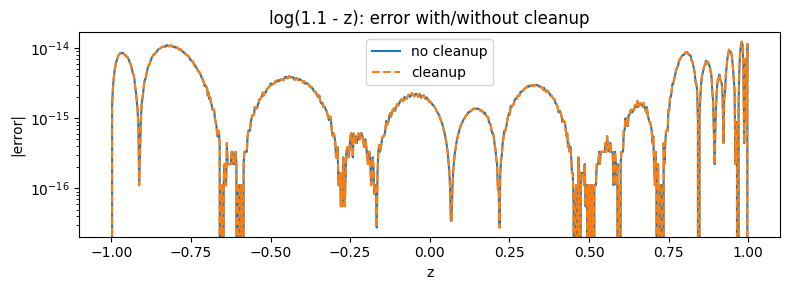

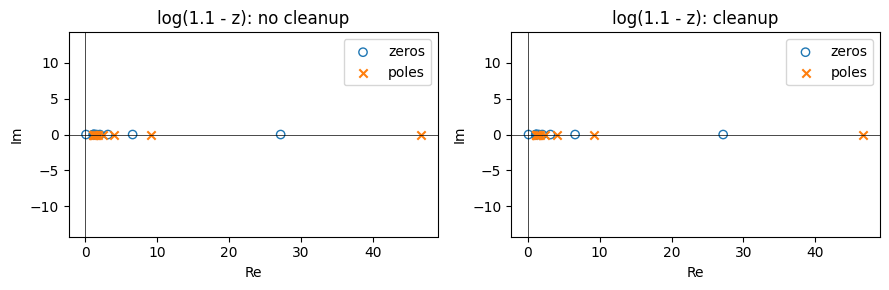

log(1.1 - z): support points (raw, clean) = 11 11


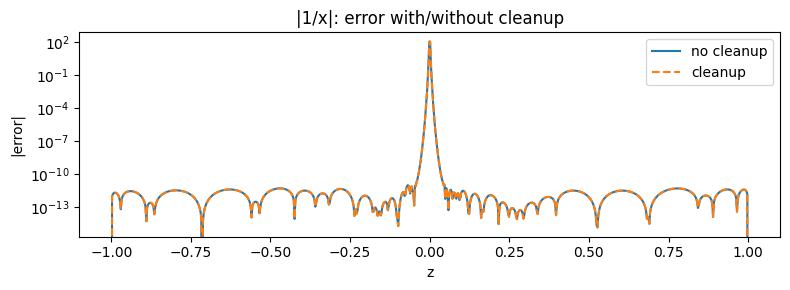

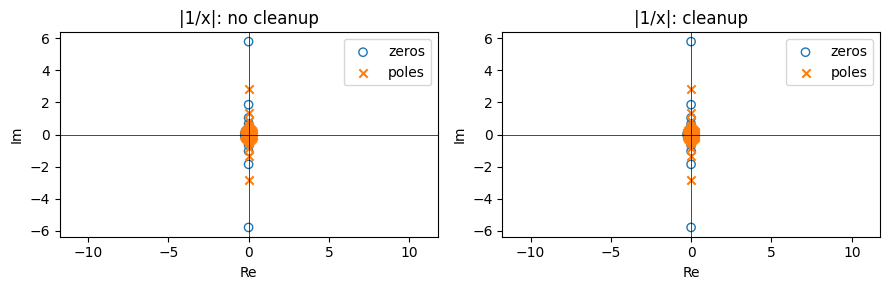

|1/x|: support points (raw, clean) = 33 33


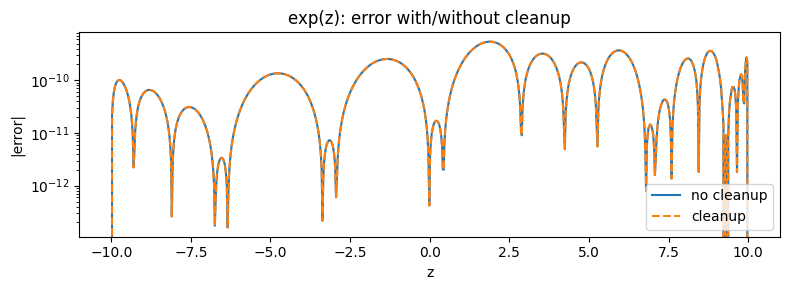

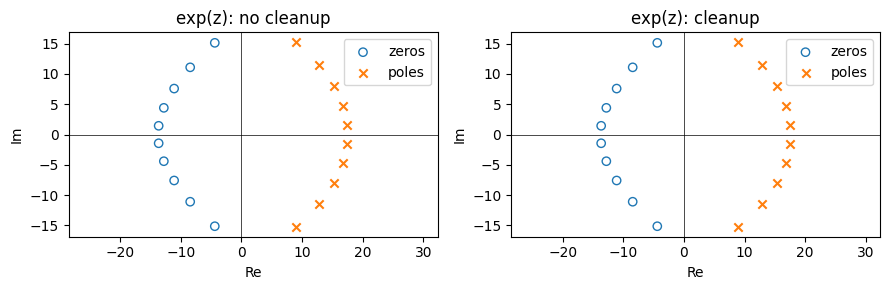

exp(z): support points (raw, clean) = 11 11


In [300]:
# Real examples: log(1.1 - z), |1/x|, exp(z) — with vs without cleanup

import numpy as np

import matplotlib.pyplot as plt



# 1) log(1.1 - z) on [-1,1]

Z1 = np.linspace(-1, 1, 400)

F1 = np.log(1.1 - Z1)

Zs_raw_1, Fs_raw_1, w_raw_1, poles_raw_1, zeros_raw_1, residues_raw_1, errs_raw_1 = aaa(F1, Z1, tol=1e-12, mmax=60, cleanup_tol=-1)

Zs_cln_1, Fs_cln_1, w_cln_1, poles_cln_1, zeros_cln_1, residues_cln_1, errs_cln_1 = aaa(F1, Z1, tol=1e-12, mmax=60, cleanup_tol=1e-13)

zz1 = np.linspace(Z1.min(), Z1.max(), 800)

F_true_1 = np.log(1.1 - zz1)

F_raw_1 = eval_rf_safe(zz1, Zs_raw_1, Fs_raw_1, w_raw_1)

F_cln_1 = eval_rf_safe(zz1, Zs_cln_1, Fs_cln_1, w_cln_1)

plt.figure(figsize=(8,3))

plt.semilogy(zz1, np.abs(F_true_1 - F_raw_1), label='no cleanup')

plt.semilogy(zz1, np.abs(F_true_1 - F_cln_1), '--', label='cleanup')

plt.xlabel('z'); plt.ylabel('|error|'); plt.title('log(1.1 - z): error with/without cleanup')

plt.legend(); plt.tight_layout(); plt.show()

fig, ax = plt.subplots(1,2, figsize=(9,3))

for j,(p,z_,title_) in enumerate([

    (poles_raw_1, zeros_raw_1, 'no cleanup'),

    (poles_cln_1, zeros_cln_1, 'cleanup')

]):

    if len(z_): ax[j].scatter(np.real(z_), np.imag(z_), facecolors='none', edgecolors='tab:blue', label='zeros')

    if len(p): ax[j].scatter(np.real(p), np.imag(p), marker='x', color='tab:orange', label='poles')

    ax[j].axhline(0, color='k', lw=0.5); ax[j].axvline(0, color='k', lw=0.5)

    ax[j].set_title(f'log(1.1 - z): {title_}')

    ax[j].set_xlabel('Re'); ax[j].set_ylabel('Im'); ax[j].axis('equal'); ax[j].legend(loc='best')

plt.tight_layout(); plt.show()

print('log(1.1 - z): support points (raw, clean) =', len(Zs_raw_1), len(Zs_cln_1))



# 2) |1/x| on [-1,1]

Z2 = np.linspace(-1, 1, 400)

Z2[np.isclose(Z2, 0.0)] = 1e-12  # avoid division by zero for visualization

F2 = np.abs(1.0 / Z2)

Zs_raw_2, Fs_raw_2, w_raw_2, poles_raw_2, zeros_raw_2, residues_raw_2, errs_raw_2 = aaa(F2, Z2, tol=1e-12, mmax=60, cleanup_tol=-1)

Zs_cln_2, Fs_cln_2, w_cln_2, poles_cln_2, zeros_cln_2, residues_cln_2, errs_cln_2 = aaa(F2, Z2, tol=1e-12, mmax=60, cleanup_tol=1e-13)

zz2 = np.linspace(Z2.min(), Z2.max(), 800)

zz2[np.isclose(zz2, 0.0)] = 1e-12

with np.errstate(divide='ignore', invalid='ignore'):

    F_true_2 = np.abs(1.0 / zz2)

F_raw_2 = eval_rf_safe(zz2, Zs_raw_2, Fs_raw_2, w_raw_2)

F_cln_2 = eval_rf_safe(zz2, Zs_cln_2, Fs_cln_2, w_cln_2)

plt.figure(figsize=(8,3))

plt.semilogy(zz2, np.abs(F_true_2 - F_raw_2.real), label='no cleanup')

plt.semilogy(zz2, np.abs(F_true_2 - F_cln_2.real), '--', label='cleanup')

plt.xlabel('z'); plt.ylabel('|error|'); plt.title('|1/x|: error with/without cleanup')

plt.legend(); plt.tight_layout(); plt.show()

fig, ax = plt.subplots(1,2, figsize=(9,3))

for j,(p,z_,title_) in enumerate([

    (poles_raw_2, zeros_raw_2, 'no cleanup'),

    (poles_cln_2, zeros_cln_2, 'cleanup')

]):

    if len(z_): ax[j].scatter(np.real(z_), np.imag(z_), facecolors='none', edgecolors='tab:blue', label='zeros')

    if len(p): ax[j].scatter(np.real(p), np.imag(p), marker='x', color='tab:orange', label='poles')

    ax[j].axhline(0, color='k', lw=0.5); ax[j].axvline(0, color='k', lw=0.5)

    ax[j].set_title(f'|1/x|: {title_}')

    ax[j].set_xlabel('Re'); ax[j].set_ylabel('Im'); ax[j].axis('equal'); ax[j].legend(loc='best')

plt.tight_layout(); plt.show()

print('|1/x|: support points (raw, clean) =', len(Zs_raw_2), len(Zs_cln_2))



# 3) exp(z) on [-10,10]

Z3 = np.linspace(-10, 10, 400)

F3 = np.exp(Z3)

Zs_raw_3, Fs_raw_3, w_raw_3, poles_raw_3, zeros_raw_3, residues_raw_3, errs_raw_3 = aaa(F3, Z3, tol=1e-12, mmax=60, cleanup_tol=-1)

Zs_cln_3, Fs_cln_3, w_cln_3, poles_cln_3, zeros_cln_3, residues_cln_3, errs_cln_3 = aaa(F3, Z3, tol=1e-12, mmax=60, cleanup_tol=1e-13)

zz3 = np.linspace(Z3.min(), Z3.max(), 800)

F_true_3 = np.exp(zz3)

F_raw_3 = eval_rf_safe(zz3, Zs_raw_3, Fs_raw_3, w_raw_3)

F_cln_3 = eval_rf_safe(zz3, Zs_cln_3, Fs_cln_3, w_cln_3)

plt.figure(figsize=(8,3))

plt.semilogy(zz3, np.abs(F_true_3 - F_raw_3.real), label='no cleanup')

plt.semilogy(zz3, np.abs(F_true_3 - F_cln_3.real), '--', label='cleanup')

plt.xlabel('z'); plt.ylabel('|error|'); plt.title('exp(z): error with/without cleanup')

plt.legend(); plt.tight_layout(); plt.show()

fig, ax = plt.subplots(1,2, figsize=(9,3))

for j,(p,z_,title_) in enumerate([

    (poles_raw_3, zeros_raw_3, 'no cleanup'),

    (poles_cln_3, zeros_cln_3, 'cleanup')

]):

    if len(z_): ax[j].scatter(np.real(z_), np.imag(z_), facecolors='none', edgecolors='tab:blue', label='zeros')

    if len(p): ax[j].scatter(np.real(p), np.imag(p), marker='x', color='tab:orange', label='poles')

    ax[j].axhline(0, color='k', lw=0.5); ax[j].axvline(0, color='k', lw=0.5)

    ax[j].set_title(f'exp(z): {title_}')

    ax[j].set_xlabel('Re'); ax[j].set_ylabel('Im'); ax[j].axis('equal'); ax[j].legend(loc='best')

plt.tight_layout(); plt.show()

print('exp(z): support points (raw, clean) =', len(Zs_raw_3), len(Zs_cln_3))


/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:56: RuntimeWarning: divide by zero encountered in divide
  C_all = 1.0 / (Z[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:56: RuntimeWarning: invalid value encountered in divide
  C_all = 1.0 / (Z[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:57: RuntimeWarning: invalid value encountered in matmul
  num_all = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:58: RuntimeWarning: invalid value encountered in matmul
  den_all = C_all @ w
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:59: RuntimeWarning: invalid value encountered in divide
  R = num_all / den_all
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/2837228830.py:57: RuntimeWarning: divide by zero encountered in matmul
  num_all = C_all @ (w * Fs

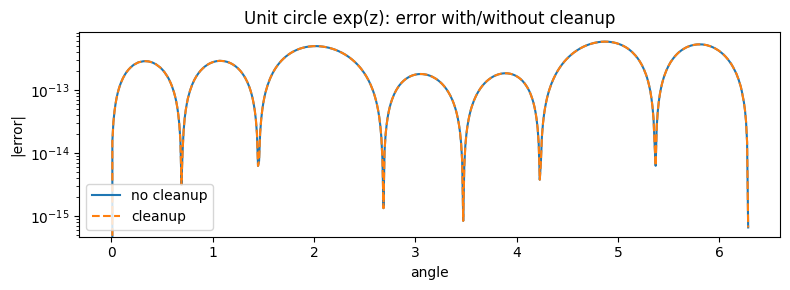

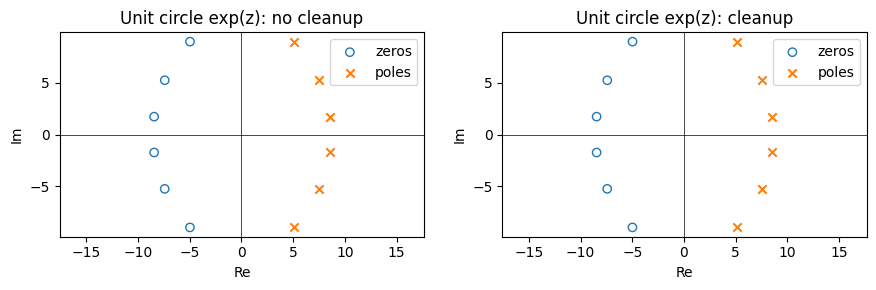

In [301]:
# Complex example: exp(z) on the unit circle — with vs without cleanup

import numpy as np

import matplotlib.pyplot as plt



# Sample on the unit circle

theta = np.linspace(0, 2*np.pi, 200)

Zc = np.exp(1j * theta)

Fc = np.exp(Zc)



# Fit without and with cleanup

rfun_raw_c, Zs_raw_c2, Fs_raw_c2, w_raw_c2 = aaa_complex(Fc, Zc, tol=1e-12, mmax=80, cleanup=False, verbose=False)

rfun_cln_c, Zs_cln_c2, Fs_cln_c2, w_cln_c2 = aaa_complex(Fc, Zc, tol=1e-12, mmax=80, cleanup=True, verbose=False)



# Evaluate on a finer grid

theta_t = np.linspace(0, 2*np.pi, 600)

Zt = np.exp(1j * theta_t)

F_true = np.exp(Zt)

F_raw = eval_rf_safe(Zt, Zs_raw_c2, Fs_raw_c2, w_raw_c2)

F_cln = eval_rf_safe(Zt, Zs_cln_c2, Fs_cln_c2, w_cln_c2)



# Error vs angle

plt.figure(figsize=(8,3))

plt.semilogy(theta_t, np.abs(F_true - F_raw), label='no cleanup')

plt.semilogy(theta_t, np.abs(F_true - F_cln), '--', label='cleanup')

plt.xlabel('angle'); plt.ylabel('|error|'); plt.title('Unit circle exp(z): error with/without cleanup')

plt.legend(); plt.tight_layout(); plt.show()



# Pole–zero comparison via barycentric_to_poly

def pz_from_bary(Zs, Fs, w):

    num, den = barycentric_to_poly(Zs, Fs, w)

    return np.roots(den), np.roots(num)



p_raw, z_raw = pz_from_bary(Zs_raw_c2, Fs_raw_c2, w_raw_c2)

p_cln, z_cln = pz_from_bary(Zs_cln_c2, Fs_cln_c2, w_cln_c2)



fig, ax = plt.subplots(1,2, figsize=(9,3))

for j,(p,z_,title_) in enumerate([

    (p_raw, z_raw, 'no cleanup'),

    (p_cln, z_cln, 'cleanup')

]):

    if len(z_): ax[j].scatter(np.real(z_), np.imag(z_), facecolors='none', edgecolors='tab:blue', label='zeros')

    if len(p): ax[j].scatter(np.real(p), np.imag(p), marker='x', color='tab:orange', label='poles')

    ax[j].axhline(0, color='k', lw=0.5); ax[j].axvline(0, color='k', lw=0.5)

    ax[j].set_title(f'Unit circle exp(z): {title_}')

    ax[j].set_xlabel('Re'); ax[j].set_ylabel('Im'); ax[j].axis('equal'); ax[j].legend(loc='best')

plt.tight_layout(); plt.show()


In [303]:
# Export key figures to mimg/ and embed in report
import os
import numpy as np
import matplotlib.pyplot as plt

# Ensure output directory exists
outdir = os.path.join(os.path.dirname(__file__) if '__file__' in globals() else '.', 'mimg')
os.makedirs(outdir, exist_ok=True)

# 1) log(1.1 - z): fit, error, and pole–zero map
Z = np.linspace(-1, 1, 400)
F = np.log(1.1 - Z)
Zs, Fs, w, poles, zeros, residues, maxerr_list = aaa(F, Z, tol=1e-12, mmax=60, cleanup_tol=1e-13)

zz = np.linspace(-1, 1, 800)
F_true = np.log(1.1 - zz)
F_approx = eval_rf_safe(zz, Zs, Fs, w).real

plt.figure(figsize=(7,3), dpi=150)
plt.plot(zz, F_true, label='log(1.1 - z)')
plt.plot(zz, F_approx, '--', label='AAA approx')
plt.scatter(Zs, Fs.real, s=25, facecolors='w', edgecolors='k', zorder=5, label='support')
plt.legend(); plt.title('AAA fit: log(1.1 - z)'); plt.tight_layout()
plt.savefig(os.path.join(outdir, 'log_fit.png')); plt.close()

plt.figure(figsize=(7,3), dpi=150)
plt.semilogy(zz, np.abs(F_true - F_approx))
plt.xlabel('z'); plt.ylabel('|error|'); plt.title('Error: log(1.1 - z)'); plt.tight_layout()
plt.savefig(os.path.join(outdir, 'log_error.png')); plt.close()

# Pole–zero map for log example
num, den = barycentric_to_poly(Zs, Fs, w)
poles_log, zeros_log = np.roots(den), np.roots(num)
plt.figure(figsize=(4,3), dpi=150)
if zeros_log.size:
    plt.scatter(zeros_log.real, zeros_log.imag, facecolors='none', edgecolors='tab:blue', label='zeros')
if poles_log.size:
    plt.scatter(poles_log.real, poles_log.imag, marker='x', color='tab:orange', label='poles')
plt.axhline(0, color='k', lw=0.5); plt.axvline(0, color='k', lw=0.5)
plt.legend(); plt.title('Pole–zero map (log)'); plt.xlabel('Re'); plt.ylabel('Im'); plt.axis('equal'); plt.tight_layout()
plt.savefig(os.path.join(outdir, 'log_pz.png')); plt.close()

# 1b) |1/x| on [-1,1]: fit, error, PZ (avoid z=0 in reference)
Z2 = np.linspace(-1, 1, 400)
Z2[np.isclose(Z2, 0.0)] = 1e-12
F2 = np.abs(1.0 / Z2)
Zs2, Fs2, w2, poles2, zeros2, residues2, _ = aaa(F2, Z2, tol=1e-12, mmax=60, cleanup_tol=1e-13)
zz2 = np.linspace(-1, 1, 800)
zz2[np.isclose(zz2, 0.0)] = 1e-12
F_true_2 = np.abs(1.0 / zz2)
F_approx_2 = eval_rf_safe(zz2, Zs2, Fs2, w2).real

plt.figure(figsize=(7,3), dpi=150)
plt.plot(zz2, F_true_2, label='|1/x|')
plt.plot(zz2, F_approx_2, '--', label='AAA approx')
plt.scatter(Zs2, Fs2.real, s=25, facecolors='w', edgecolors='k', zorder=5, label='support')
plt.legend(); plt.title('AAA fit: |1/x| on [-1,1]'); plt.tight_layout()
plt.savefig(os.path.join(outdir, 'invabs_fit.png')); plt.close()

plt.figure(figsize=(7,3), dpi=150)
plt.semilogy(zz2, np.abs(F_true_2 - F_approx_2))
plt.xlabel('z'); plt.ylabel('|error|'); plt.title('Error: |1/x| on [-1,1]'); plt.tight_layout()
plt.savefig(os.path.join(outdir, 'invabs_error.png')); plt.close()

num2, den2 = barycentric_to_poly(Zs2, Fs2, w2)
poles2_r, zeros2_r = np.roots(den2), np.roots(num2)
plt.figure(figsize=(4,3), dpi=150)
if zeros2_r.size:
    plt.scatter(zeros2_r.real, zeros2_r.imag, facecolors='none', edgecolors='tab:blue', label='zeros')
if poles2_r.size:
    plt.scatter(poles2_r.real, poles2_r.imag, marker='x', color='tab:orange', label='poles')
plt.axhline(0, color='k', lw=0.5); plt.axvline(0, color='k', lw=0.5)
plt.legend(); plt.title('Pole–zero map (|1/x|)'); plt.xlabel('Re'); plt.ylabel('Im'); plt.axis('equal'); plt.tight_layout()
plt.savefig(os.path.join(outdir, 'invabs_pz.png')); plt.close()

# 1c) exp(z) on [-10,10]: fit, error, PZ
Z3 = np.linspace(-10, 10, 400)
F3 = np.exp(Z3)
Zs3, Fs3, w3, poles3, zeros3, residues3, _ = aaa(F3, Z3, tol=1e-12, mmax=60, cleanup_tol=1e-13)
zz3 = np.linspace(-10, 10, 800)
F_true_3 = np.exp(zz3)
F_approx_3 = eval_rf_safe(zz3, Zs3, Fs3, w3).real

plt.figure(figsize=(7,3), dpi=150)
plt.plot(zz3, F_true_3, label='exp(z)')
plt.plot(zz3, F_approx_3, '--', label='AAA approx')
plt.scatter(Zs3, Fs3.real, s=25, facecolors='w', edgecolors='k', zorder=5, label='support')
plt.legend(); plt.title('AAA fit: exp(z) on [-10,10]'); plt.tight_layout()
plt.savefig(os.path.join(outdir, 'exp_fit.png')); plt.close()

plt.figure(figsize=(7,3), dpi=150)
plt.semilogy(zz3, np.abs(F_true_3 - F_approx_3))
plt.xlabel('z'); plt.ylabel('|error|'); plt.title('Error: exp(z) on [-10,10]'); plt.tight_layout()
plt.savefig(os.path.join(outdir, 'exp_error.png')); plt.close()

num3, den3 = barycentric_to_poly(Zs3, Fs3, w3)
poles3_r, zeros3_r = np.roots(den3), np.roots(num3)
plt.figure(figsize=(4,3), dpi=150)
if zeros3_r.size:
    plt.scatter(zeros3_r.real, zeros3_r.imag, facecolors='none', edgecolors='tab:blue', label='zeros')
if poles3_r.size:
    plt.scatter(poles3_r.real, poles3_r.imag, marker='x', color='tab:orange', label='poles')
plt.axhline(0, color='k', lw=0.5); plt.axvline(0, color='k', lw=0.5)
plt.legend(); plt.title('Pole–zero map (exp)'); plt.xlabel('Re'); plt.ylabel('Im'); plt.axis('equal'); plt.tight_layout()
plt.savefig(os.path.join(outdir, 'exp_pz.png')); plt.close()

# 2) ζ(s) on real axis: error plot
s_train = np.linspace(1.1, 4.0, 500)
F_train = zeta(s_train, N=2000)
Zs_r, Fs_r, w_r, _, _, _, _ = aaa(F_train, s_train, tol=1e-12, mmax=60)

s_test = np.linspace(1.1, 4.0, 1200)
F_true_r = zeta(s_test, N=2000)
F_approx_r = eval_rf_safe(s_test, Zs_r, Fs_r, w_r)
plt.figure(figsize=(7,3), dpi=150)
plt.semilogy(s_test, np.abs(F_true_r - F_approx_r))
plt.xlabel('s'); plt.ylabel('|error|'); plt.title('ζ(s) real axis error'); plt.tight_layout()
plt.savefig(os.path.join(outdir, 'zeta_real_error.png')); plt.close()

# 3) ζ(1/2 + i t) critical line: error plot
# Use deterministic sampling for reproducibility
t_train = np.linspace(0.0, 40.0, 800)
s_line = 0.5 + 1j * t_train
F_line = zeta(s_line, N=2000)
rfun_c, Zs_c, Fs_c, w_c = aaa_complex(F_line, s_line, tol=1e-11, mmax=80, cleanup=True, verbose=False)

t_test = np.linspace(0.0, 40.0, 801)
s_test_c = 0.5 + 1j * t_test
F_true_c = zeta(s_test_c, N=2000)
F_approx_c = eval_rf_safe(s_test_c, Zs_c, Fs_c, w_c)
plt.figure(figsize=(7,3), dpi=150)
plt.semilogy(t_test, np.abs(F_true_c - F_approx_c))
plt.xlabel('t'); plt.ylabel('|error|'); plt.title('ζ(1/2 + i t) critical line error'); plt.tight_layout()
plt.savefig(os.path.join(outdir, 'zeta_critical_error.png')); plt.close()

# 4) Complex unit circle exp(z): error vs angle and PZ map
theta = np.linspace(0, 2*np.pi, 200)
Zc = np.exp(1j * theta)
Fc = np.exp(Zc)
rfun_uc, Zs_uc, Fs_uc, w_uc = aaa_complex(Fc, Zc, tol=1e-12, mmax=80, cleanup=True, verbose=False)

theta_t = np.linspace(0, 2*np.pi, 600)
Zt = np.exp(1j * theta_t)
F_true_uc = np.exp(Zt)
F_approx_uc = eval_rf_safe(Zt, Zs_uc, Fs_uc, w_uc)
plt.figure(figsize=(7,3), dpi=150)
plt.semilogy(theta_t, np.abs(F_true_uc - F_approx_uc))
plt.xlabel('angle (rad)'); plt.ylabel('|error|'); plt.title('exp(z) on unit circle: error'); plt.tight_layout()
plt.savefig(os.path.join(outdir, 'complex_circle_error.png')); plt.close()

# PZ for unit circle example
num_uc, den_uc = barycentric_to_poly(Zs_uc, Fs_uc, w_uc)
p_uc, z_uc = np.roots(den_uc), np.roots(num_uc)
plt.figure(figsize=(4,3), dpi=150)
if z_uc.size:
    plt.scatter(z_uc.real, z_uc.imag, facecolors='none', edgecolors='tab:blue', label='zeros')
if p_uc.size:
    plt.scatter(p_uc.real, p_uc.imag, marker='x', color='tab:orange', label='poles')
plt.axhline(0, color='k', lw=0.5); plt.axvline(0, color='k', lw=0.5)
plt.legend(); plt.title('Pole–zero map (unit circle exp)'); plt.xlabel('Re'); plt.ylabel('Im'); plt.axis('equal'); plt.tight_layout()
plt.savefig(os.path.join(outdir, 'complex_circle_pz.png')); plt.close()

print('Saved figures to', outdir)

/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:51: RuntimeWarning: divide by zero encountered in divide
  C_all = 1.0 / (Z[:, None] - Zs[None, :])
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:54: RuntimeWarning: invalid value encountered in divide
  R = N / D
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: divide by zero encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: overflow encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:52: RuntimeWarning: invalid value encountered in matmul
  N = C_all @ (w * Fs)
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel_24263/470922225.py:53: RuntimeWarning: divide by zero encountered in matmul
  D = C_all @ w
/var/folders/3t/vh6xhhgx05s3cyb0tmq2tp700000gn/T/ipykernel

Saved figures to ./mimg
